In [3]:
import sys
sys.path.append('/home/es534/.conda/envs/jupyterhub-packages/lib/python3.7/site-packages')

In [4]:
# also import helpful modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import glob
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import cv2
# import gdal, ogr, osr, os
# import geopandas as gpd

### Load Shape File

In [60]:
feature_files = glob.glob('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/*tif')
feature_files

['/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Med_vh.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Std_vv.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_MVC_NDVI_Resampled.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_DEM_Resampled.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Std_vh.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Mean_vh.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Med_vv.tif',
 '/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Mean_vv.tif']

In [61]:
for f in feature_files:
    #Calculate image pixel resolution using bounds info
    ras = rasterio.open(f)
    print((ras.bounds.right - ras.bounds.left)/(ras.width)*1000)

0.08983152841195194
0.08983152841195194
0.08983152841195194
0.08983152841195194
0.08983152841195194
0.08983152841195194
0.08983152841195194
0.08983152841195194


### Create Training Data

In [57]:
lc_df = pd.read_csv('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/Training_data_new_new.csv')

In [58]:
lc_df.head()

,Mean_VV,Med_VV,STD_VV,Mean_VH,Med_VH,STD_VH,DEM,NDVI,Class
0,-3.189590,-2.763431,2.117182,-10.849805,-10.912839,0.665487,42.031113,0.765323,0
1,-3.920457,-4.361404,1.344206,-10.194673,-10.037989,0.665202,21.568129,0.796087,0
2,-2.893843,-3.109851,0.741187,-9.531433,-10.178471,1.023670,21.568129,0.800848,0
3,-2.803445,-2.844810,1.110690,-10.154666,-10.490068,1.681226,21.568129,0.804252,0
4,-3.420836,-3.808960,1.079128,-12.151341,-11.658836,0.917422,45.000000,0.812472,0


## Introduce NoData class into training data to take care of nodata pixels in the images

In [67]:
no_data = np.zeros((len(lc_df.columns), 300))
no_data[0:len(lc_df.columns)-1,:] = -9999
no_data[len(lc_df.columns)-1,:] = 9
nd_df = pd.DataFrame(no_data.T)

new_dat = np.concatenate((nd_df.values, lc_df.values))
new_df = pd.DataFrame(new_dat, columns=lc_df.columns)
new_dat1 = new_df.sample(frac=1, random_state=1)

In [69]:
new_dat1.describe()

,Mean_VV,Med_VV,STD_VV,Mean_VH,Med_VH,STD_VH,DEM,NDVI,Class
count,43555.000000,43555.000000,43555.000000,43555.000000,43555.000000,43555.000000,43555.000000,43555.000000,43555.000000
mean,-75.700651,-75.688386,-67.318179,-81.781246,-81.755370,-67.361041,-18.076991,-68.406750,1.836804
std,826.448694,826.450443,827.123995,825.938421,825.941101,827.120251,831.537043,827.032763,1.853958
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000
25%,-8.910910,-8.965545,0.841473,-14.862645,-14.889038,0.848439,32.512516,0.055413,0.000000
50%,-4.834226,-4.928756,1.348863,-11.560738,-11.548603,1.349353,51.340190,0.765290,2.000000
75%,-3.138938,-3.027808,1.980224,-9.967760,-9.839333,1.983310,70.970460,0.819366,3.000000
max,22.405737,22.488410,12.065366,11.090819,11.024836,9.560002,87.674034,0.876163,9.000000


### Create Data to classify

In [63]:
def getAllPix():
    all_df = pd.DataFrame()
    df_ls = []
    mean_vv =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Mean_vv.tif').read(1)
    med_vv =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Med_vv.tif').read(1)
    std_vv =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Std_vv.tif').read(1)
    
    mean_vh =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Mean_vh.tif').read(1)
    med_vh =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Med_vh.tif').read(1)
    std_vh =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_Std_vh.tif').read(1)
    
    dem =rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_DEM_Resampled.tif').read(1)
    ndvi=rasterio.open('/lustre/scratch/DISCUS/ASTROCAST/Banana/Data/processed/new_feat_MVC_NDVI_Resampled.tif').read(1)
    

    df_ls.append(pd.DataFrame({'Mean_VV':mean_vv.ravel(),
                                'Med_VV':med_vv.ravel(),
                                'STD_VV':std_vv.ravel(),
                                 'Mean_VH':mean_vh.ravel(),
                                'Med_VH':med_vh.ravel(),
                                'STD_VH':std_vh.ravel(),
                                'DEM':dem.ravel(),
                                'NDVI':ndvi.ravel()}))
    
    all_df = pd.concat(df_ls, axis=0)
    return all_df

In [64]:
test_df = getAllPix()

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193416504 entries, 0 to 193416503
Data columns (total 8 columns):
Mean_VV    float32
Med_VV     float32
STD_VV     float32
Mean_VH    float32
Med_VH     float32
STD_VH     float32
DEM        float32
NDVI       float32
dtypes: float32(8)
memory usage: 5.8 GB


In [66]:
test_df1 = test_df.replace(0.0, -9999)
test_df3 = test_df1.fillna(-9999)
test_df3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193416504 entries, 0 to 193416503
Data columns (total 8 columns):
Mean_VV    193416504 non-null float32
Med_VV     193416504 non-null float32
STD_VV     193416504 non-null float32
Mean_VH    193416504 non-null float32
Med_VH     193416504 non-null float32
STD_VH     193416504 non-null float32
DEM        193416504 non-null float32
NDVI       193416504 non-null float32
dtypes: float32(8)
memory usage: 5.8 GB


In [196]:
# test_df1.to_csv('All_data_new.csv', index=False)

### Data Visualize and Randomforest Classifier

In [17]:
# plt.figure(figsize=(10,8))
# sns.pairplot(lc_df, hue='Class')

In [70]:
X = new_dat1.iloc[:,:8].values
y = new_dat1.iloc[:,8].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 5)

In [72]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10)
clf.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
clf.feature_importances_

array([0.16029088, 0.11011224, 0.0106745 , 0.11196583, 0.09494824,
       0.00611213, 0.18535286, 0.32054332])

In [73]:
y_pred = clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9753577714854212

In [74]:
all_img = test_df3.values
pred_class = clf.predict(all_img)

In [5]:
# shp=rasterio.open(feature_files[1]).read(1).shape

# land_class = pred_class.reshape(shp[0], shp[1])
land_class = np.load('/lustre/scratch/DISCUS/ASTROCAST/Banana/class_maps/lc_class_new.npy')
land_class[land_class==5]=4
land_class[land_class==9]=5

In [6]:
banana = (land_class==0)*1.0
banana[banana==0]=np.nan

In [7]:
# np.save('/lustre/scratch/DISCUS/ASTROCAST/Banana/lc_class_new.npy', land_class)

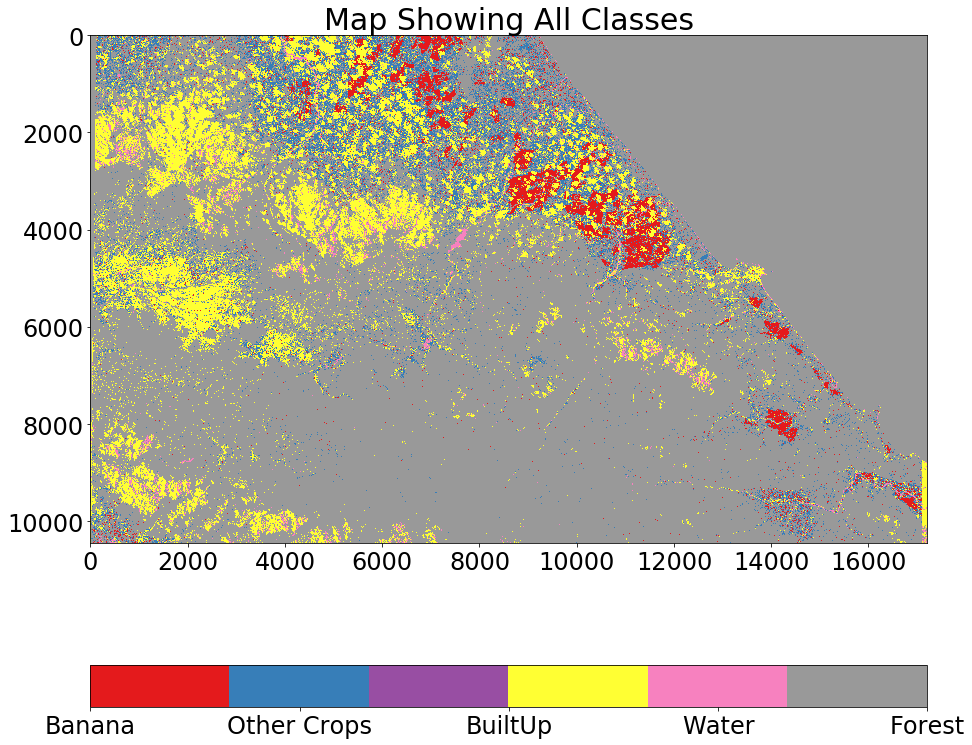

In [8]:
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap('Set1', 6)
ticks = [0, 1, 2, 3, 4, 5]
plt.imshow(land_class[800:,:], cmap=cmap)
plt.title('Map Showing All Classes', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
cbar = plt.colorbar(ticks=ticks, orientation='horizontal')
cbar.set_ticklabels(['Banana', 'Other Crops', 'BuiltUp', 'Water', 'Forest', 'No Data'])
cbar.ax.tick_params(labelsize=24)
# plt.savefig('Classfication_AOI_main.pdf', dpi=600, bbox_inches = "tight")

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text yticklabel objects>)

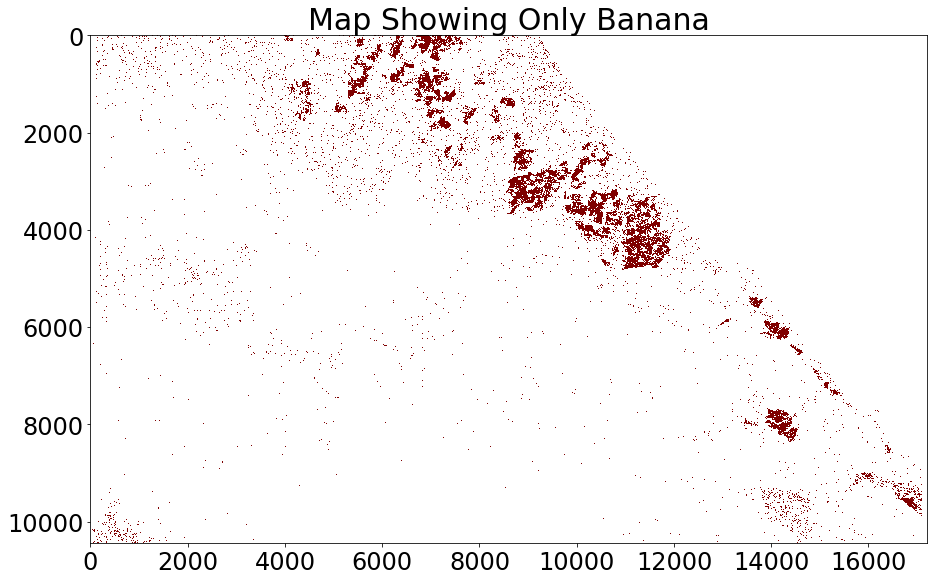

In [9]:
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(banana[800:,:], cmap=cmap)
plt.title('Map Showing Only Banana', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# cbar = plt.colorbar(ticks=ticks, orientation='horizontal')
# cbar.set_ticklabels(['Banana', 'Other Crops', 'BuiltUp', 'Water', 'Forest', 'No Data'])
# cbar.ax.tick_params(labelsize=24)
# plt.savefig('Classfication_AOI_main.pdf', dpi=600, bbox_inches = "tight")

In [125]:
# cmap = plt.cm.get_cmap('jet', 6)
# ticks = [0, 1, 2, 3, 4, 5]
# plt.figure(figsize=(15,15))
# plt.imshow(land_class[3000:6000,8000:12000], cmap=cmap)
# plt.colorbar(ticks=ticks, orientation='horizontal')

In [25]:
# np.save('/lustre/scratch/DISCUS/ASTROCAST/Banana/lc_class.npy', land_class)

In [26]:
np.unique(land_class)

array([0., 1., 2., 3., 5., 9.])

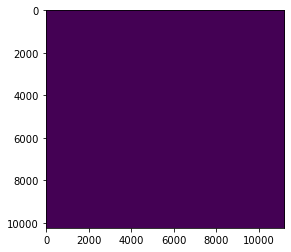

In [11]:
plt.imshow(land_class[1000:,6000:]==9)

In [13]:
banana2 = (land_class==0)*1.0

## Connected Componenets patch filtering

In [16]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img1, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1

min_size = 50  
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255

In [17]:
img3 = img2*1.0
img3[img3==0.0]=np.nan

Text(0.5, 1.0, 'Map Showing Only Banana')

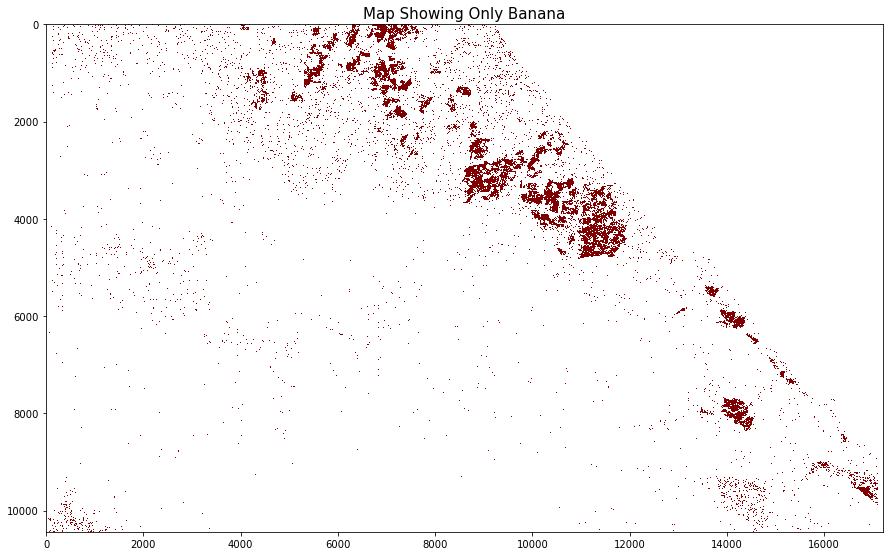

In [18]:
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(banana[800:,:], cmap=cmap)
plt.title('Map Showing Only Banana', fontsize=15)

Text(0.5, 1.0, 'Map Showing Only Banana(No Outliers)')

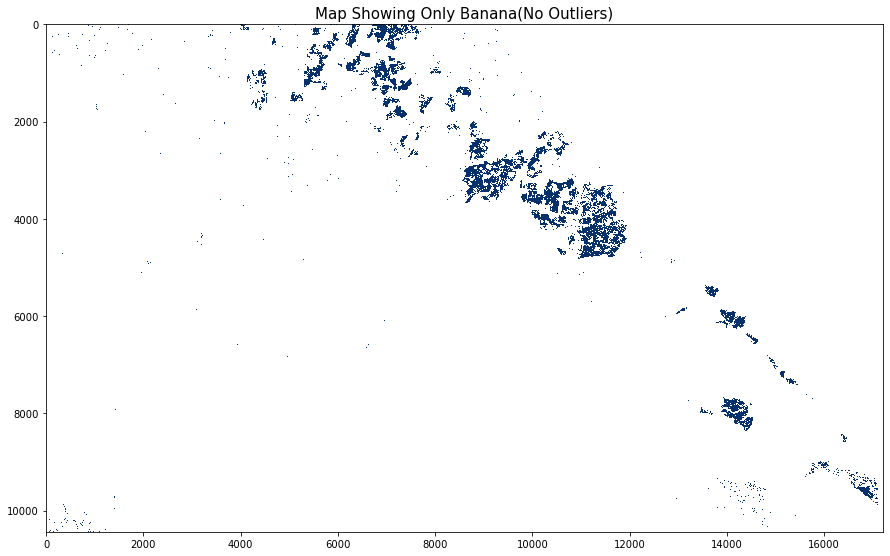

In [19]:
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap('Blues', 1)
ticks = [1]
plt.imshow(img3[800:,:], cmap=cmap)
plt.title('Map Showing Only Banana(No Outliers)', fontsize=15)

Text(0.5, 1.0, 'Map Showing Only Banana(No Outliers)')

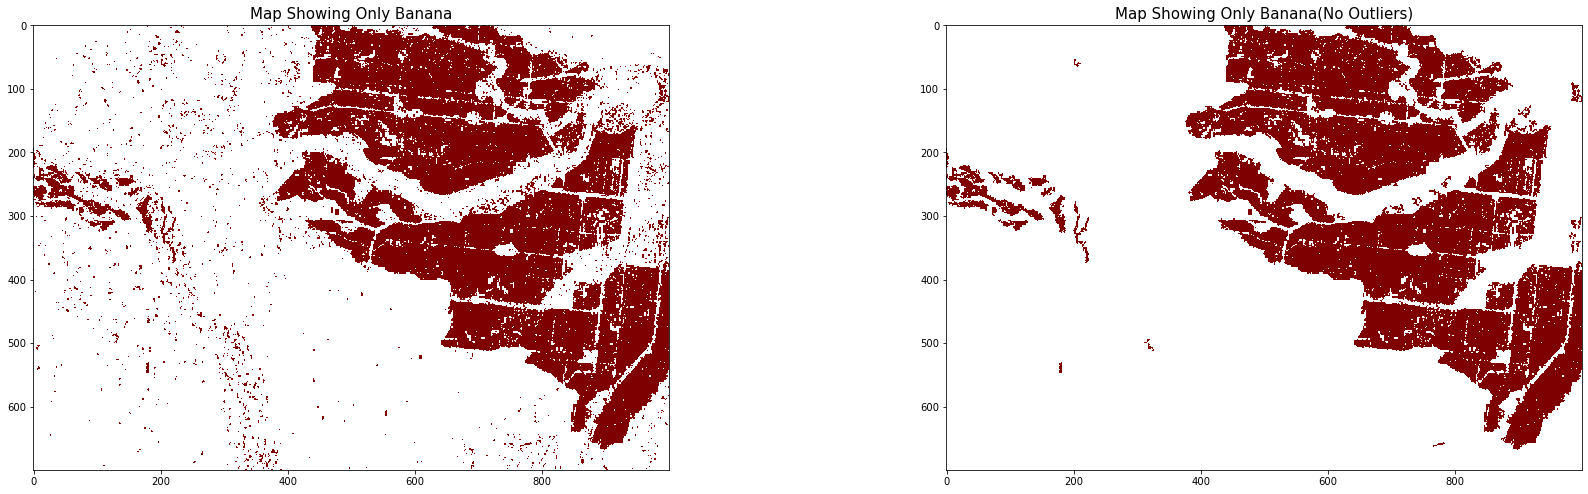

In [103]:
plt.figure(figsize=(30,18))
plt.subplot(221)
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(banana[8500:9200,13500:14500], cmap=cmap)
plt.title('Map Showing Only Banana', fontsize=15)

plt.subplot(222)
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(img3[8500:9200,13500:14500], cmap=cmap)
plt.title('Map Showing Only Banana(No Outliers)', fontsize=15)


Text(0.5, 1.0, 'Map Showing Only Banana(No Outliers)')

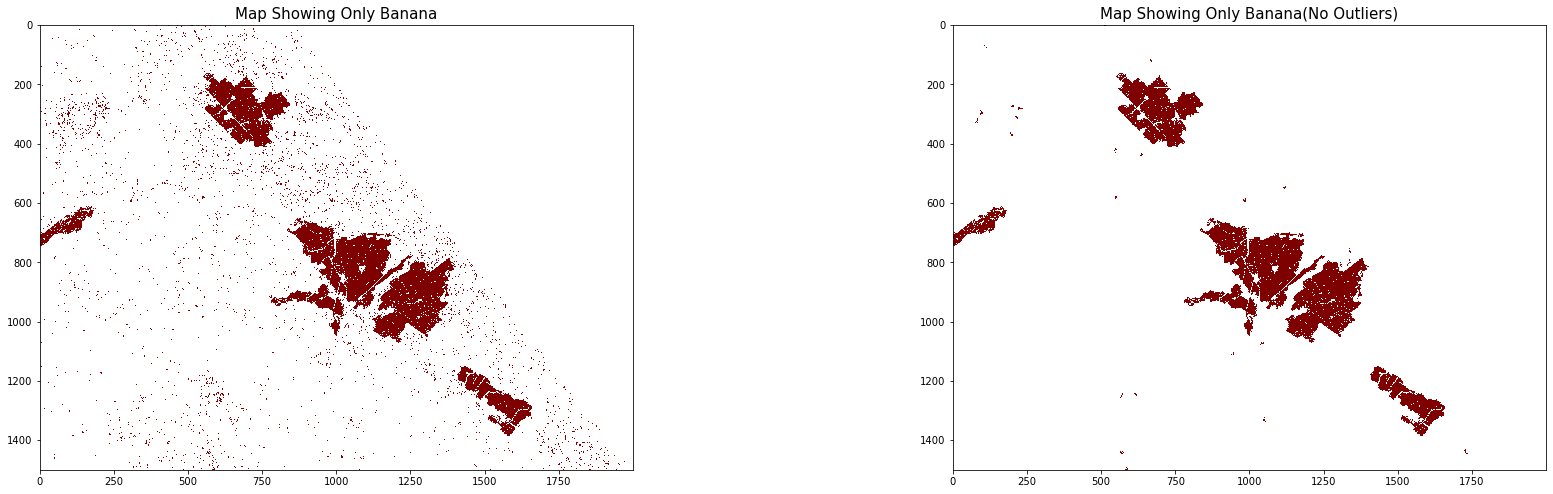

In [112]:
plt.figure(figsize=(30,18))
plt.subplot(221)
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(banana[6000:7500,13000:15000], cmap=cmap)
plt.title('Map Showing Only Banana', fontsize=15)

plt.subplot(222)
cmap = plt.cm.get_cmap('jet', 1)
ticks = [1]
plt.imshow(img3[6000:7500,13000:15000], cmap=cmap)
plt.title('Map Showing Only Banana(No Outliers)', fontsize=15)
